In [1]:
import pandas as pd
import geopandas as gpd
import requests

gdf = gpd.read_file('sample_counties.zip')

gdf.head()

,addresslin,city,state,postcode,STRCT_ID,FIPS,LAG_FT,HAG_FT,FFH_FT,distance,geometry
0,850 SANITARIUM RD,DEER PARK,CA,94576,321322448,06055,737.2,746.5,1.0,2.163731,"POLYGON ((-13634242.567 4657503.252, -13634201..."
1,6275 POPE VALLEY RD,POPE VALLEY,CA,94567,321323095,06055,786.0,787.5,2.5,8.188314,"POLYGON ((-13630273.036 4667817.384, -13630272..."
2,1091 DEER PARK RD,DEER PARK,CA,94576,321318798,06055,920.4,924.3,0.5,2.396930,"POLYGON ((-13633464.716 4658243.785, -13633461..."
3,6299 POPE VALLEY RD,POPE VALLEY,CA,94567,321323097,06055,900.3,908.1,1.0,7.769890,"POLYGON ((-13631055.888 4667702.827, -13631053..."
4,7161 POPE VALLEY RD,POPE VALLEY,CA,94567,321322836,06055,723.6,725.4,1.0,9.882574,"POLYGON ((-13632835.511 4671435.407, -13632839..."


In [2]:
(gdf['distance']<=10).sum()

12902

In [3]:
gdf['bounds'] = gdf['geometry'].apply(lambda x: x.bounds)


In [4]:
gdf['bounds'].head()

0    (-13634245.262231244, 4657481.981307929, -1363...
1    (-13630281.127521357, 4667806.49151715, -13630...
2    (-13633479.193500293, 4658213.007101163, -1363...
3    (-13631078.539850373, 4667684.027553532, -1363...
4    (-13632839.100375235, 4671435.4065716555, -136...
Name: bounds, dtype: object

In [5]:
gdf.shape

(12902, 12)

In [6]:
[[list(x) for x in gdf['geometry'].values[1].exterior.coords]]

[[[-13630273.036213966, 4667817.384206919],
  [-13630272.463350728, 4667806.93894032],
  [-13630280.554649884, 4667806.49151715],
  [-13630281.127521357, 4667816.93678295],
  [-13630273.036213966, 4667817.384206919]]]

In [7]:
gdf['bounds'].values[2]

(-13633479.193500293,
 4658213.007101163,
 -13633461.299652237,
 4658243.785465197)

In [8]:
gdf['xrange'] = gdf['bounds'].apply(lambda x: x[2] - x[0])
gdf['yrange'] = gdf['bounds'].apply(lambda x: x[3] - x[1])

In [9]:
gdf[['xrange','yrange']].head()

,xrange,yrange
0,43.769717,21.270948
1,8.664171,10.892690
2,17.893848,30.778364
3,24.998512,26.926811
4,7.853890,8.381068


In [10]:
gdf['centroid'] = gdf['geometry'].centroid

In [11]:
bl = gdf['centroid'].values[0]
bl.x, bl.y

(-13634223.37738705, 4657492.616778482)

In [13]:
import numpy as np
points = np.concatenate([gdf['centroid'].apply(lambda x: x.x)[...,np.newaxis],gdf['centroid'].apply(lambda x: x.y)[...,np.newaxis]],axis=1)

/tmp/ipykernel_28044/1818423848.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = np.concatenate([gdf['centroid'].apply(lambda x: x.x)[...,np.newaxis],gdf['centroid'].apply(lambda x: x.y)[...,np.newaxis]],axis=1)
/tmp/ipykernel_28044/1818423848.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = np.concatenate([gdf['centroid'].apply(lambda x: x.x)[...,np.newaxis],gdf['centroid'].apply(lambda x: x.y)[...,np.newaxis]],axis=1)


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=300, random_state=0).fit(points)

In [15]:
gdf['cluster'] = kmeans.labels_

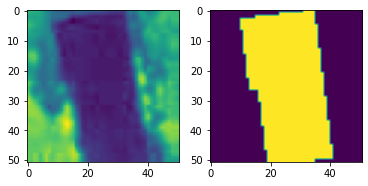

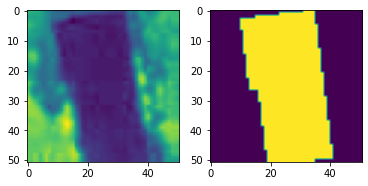

In [202]:
import json
from skimage.io import *
import cv2
base_url = 'https://map.dfg.ca.gov/arcgis/rest/services/Base_Remote_Sensing/NAIP_2020_4Band/ImageServer/exportImage'
base_params = {'size': '100,100',
 'bbox': '-13633962.905739617,4656956.569552841,-13633943.32174443,4656975.989569257',
 'f': 'json',
 'interpolation': 'RSP_BilinearInterpolation',
 'pixelType': 'U8',
 'format': 'jpgpng',
'renderingRule':'''{
                 "rasterFunction" : "NDVI",
  "rasterFunctionArguments" : {
    "VisibleBandID" : 0,
    "InfraredBandID" : 3
                    },
               "outputPixelType": "U8"
             }'''}

def convert_coords(coords,xmin,ymin,xmax,ymax,multiplier=100,**kwargs):
    new_coords=[]
    
    for x,y in coords:
        new_x = int(((x-xmin)/(xmax-xmin)) * multiplier)
        new_y = multiplier - int(((y-ymin)/(ymax-ymin)) * multiplier)
        new_coords.append((new_x,new_y))
    return new_coords

def create_request(base_url=base_url,**kwargs):
    if 'bbox' not in kwargs.keys():
        raise('At least bbox is required to run this request')
    for x in ['f','size','interpolation','pixelType','format','renderingRule']:
        if x not in kwargs.keys():
            kwargs[x] = base_params[x]
    return requests.get(base_url,params=kwargs)

def calculate_tree_coverage(geometry,nvdi_threshold=[120,160],ret_nvdi=False):
    bounds = geometry.bounds
    size = round(max((geometry.bounds[2] - geometry.bounds[0]),(geometry.bounds[3] - geometry.bounds[1]))/.6)
    bbox = ','.join([str(x) for x in geometry.bounds])
    resp = create_request(bbox=bbox,size=f'{str(size)},{str(size)}')
    the_dict = json.loads(resp.content)

    nvdi = imread(the_dict['href'])
    drawing = np.zeros([size, size],np.uint8)
    contours = np.array(convert_coords(coords =[x for x in geometry.exterior.coords],multiplier=size, **the_dict['extent']))
    cv2.drawContours(drawing,[contours],0,1,cv2.FILLED)
    tree_cov_dict = {}
    for thresholds in nvdi_threshold:
        tree_coverage = ((nvdi>thresholds) & (drawing==1)).sum()/(drawing.sum())
        tree_cov_dict[f'nvdi_cov_single_{str(thresholds)}'] = tree_coverage
    tree_cov_dict[f'nvdi_score_single'] = nvdi[drawing==1].mean()
    if ret_nvdi:
        return nvdi, tree_cov_dict, drawing
    return tree_cov_dict


nvdi, tree_cov, drawing = calculate_tree_coverage(gdf['geometry'].values[2],ret_nvdi=True)
imshow_collection([nvdi,drawing])

In [203]:
print(tree_cov)

{'nvdi_cov_single_120': 0.003418803418803419, 'nvdi_cov_single_160': 0.0, 'nvdi_score_single': 75.2991452991453}


In [139]:
44/.6

73.33333333333334

In [142]:
test_geo.bounds

(-13634245.262231244,
 4657481.981307929,
 -13634201.492514538,
 4657503.252256295)

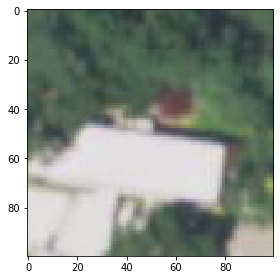

In [141]:
test_geo = gdf['geometry'].values[0]
imshow(imread(json.loads(create_request(bbox=','.join([str(x) for x in test_geo.bounds]),renderingRule='',size='100,100').content)['href']))

In [51]:
from joblib import Parallel,delayed
import os
base_dir = '/mnt/data/the_tiffs'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [52]:
cluster_bounds = gdf.groupby('cluster').apply(lambda group: [group['bounds'].apply(lambda x:x[0]).min(),group['bounds'].apply(lambda x:x[1]).min(),group['bounds'].apply(lambda x:x[2]).max(),group['bounds'].apply(lambda x:x[3]).max()])
cluster_bounds = cluster_bounds.reset_index()

In [53]:
cluster_bounds.columns = ['cluster','bounds']

In [174]:
make_file_list = cluster_bounds['cluster'].apply(lambda x: f'cluster_{str(x)}.tiff').tolist()
bounds_list = cluster_bounds['bounds'].tolist()

def base_function(bounds,file):
    size = round(max((bounds[2] - bounds[0]),(bounds[3] - bounds[1]))/.6)
    req = create_request(bbox=','.join([str(x) for x in bounds]),size=f'{str(size)},{str(size)}',f='json',format='tiff')
    the_dict = json.loads(req.content)
    with open(file,'wb') as f:
        f.write(requests.get(the_dict['href']).content)
    return the_dict
reget=True
if reget:
    those_dicts = Parallel(n_jobs=10,backend='threading')(delayed(base_function)(bounds=bounds,file=os.path.join(base_dir,file)) for bounds,file in zip(bounds_list,make_file_list))

In [175]:
if reget:
    cluster_bounds['extent'] = pd.Series([[val['extent']['xmin'],val['extent']['ymin'],val['extent']['xmax'],val['extent']['ymax']] for val in those_dicts])
    cluster_bounds['tiff_file'] = cluster_bounds['cluster'].apply(lambda x: os.path.join(base_dir,f'cluster_{str(x)}.tiff'))
    cluster_bounds.to_pickle('cluster.pkl')
else:
    cluster_bounds = pd.read_pickle('cluster.pkl')

In [194]:
def transform_tiffs(tiff):
    data = imread(tiff)
    new_data = (((data[...,3] - data[...,0]) / ((data[...,3] + data[...,0])+.0001)) * 100 + 100).astype(np.uint8)
    return new_data

def calculate_tree_coverage_by_cluster(cluster,nvdi_threshold=[120,160],transform_tiff=True):
    tree_coverage_map = []
    recs = gdf.loc[gdf['cluster']==cluster,['STRCT_ID','geometry']].to_dict('records')
    cluster_info = cluster_bounds.loc[cluster_bounds['cluster']==cluster].to_dict('records')[0]
    extent = cluster_info['extent']
    cluster_file = cluster_info['tiff_file']
    if transform_tiff:
        cluster_array = transform_tiffs(cluster_file)
    else:
        cluster_array = imread(cluster_file)
    for rec in recs:
        base_dict = {}
        base_dict['STRCT_ID'] = rec['STRCT_ID']
        drawing = np.zeros(cluster_array.shape,np.uint8)
        contours = np.array(convert_coords(coords =[x for x in rec['geometry'].exterior.coords], xmin=extent[0],ymin=extent[1],xmax=extent[2],ymax=extent[3],multiplier=1000))
        cv2.drawContours(drawing,[contours],0,1,cv2.FILLED)
        
        for thresholds in nvdi_threshold:
            tree_coverage = ((cluster_array>thresholds) & (drawing==1)).sum()/(drawing.sum()+1e-3)
            base_dict[f'nvdi_cov_{str(thresholds)}'] = tree_coverage
        base_dict[f'nvdi_score'] = cluster_array[drawing==1].mean()
        tree_coverage_map.append(base_dict)
    return tree_coverage_map


tree_coverages = Parallel(n_jobs=8,backend='multiprocessing')(delayed(calculate_tree_coverage_by_cluster)(cluster=x,transform_tiff=False) for x in cluster_bounds['cluster'].tolist())


/tmp/ipykernel_28044/1737569906.py:26: RuntimeWarning: Mean of empty slice.
  base_dict[f'nvdi_score'] = cluster_array[drawing==1].mean()
/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_28044/1737569906.py:26: RuntimeWarning: Mean of empty slice.
  base_dict[f'nvdi_score'] = cluster_array[drawing==1].mean()
/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_28044/1737569906.py:26: RuntimeWarning: Mean of empty slice.
  base_dict[f'nvdi_score'] = cluster_array[drawing==1].mean()
/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_28044/1737569906.py:26

In [195]:
cluster_bounds['area'] = cluster_bounds['bounds'].apply(lambda bounds:(bounds[2]-bounds[0]) * (bounds[3] - bounds[1]))

In [196]:
cluster_bounds.values[223]

array([223,
       list([-13646909.981563224, 4652018.83401346, -13645809.727581717, 4653381.924213535]),
       list([-13647041.399672508, 4652018.834013459, -13645678.309472434, 4653381.924213534]),
       '/mnt/data/the_tiffs/cluster_223.tiff', 1499745.4197848882],
      dtype=object)

(1165, 1165)


/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


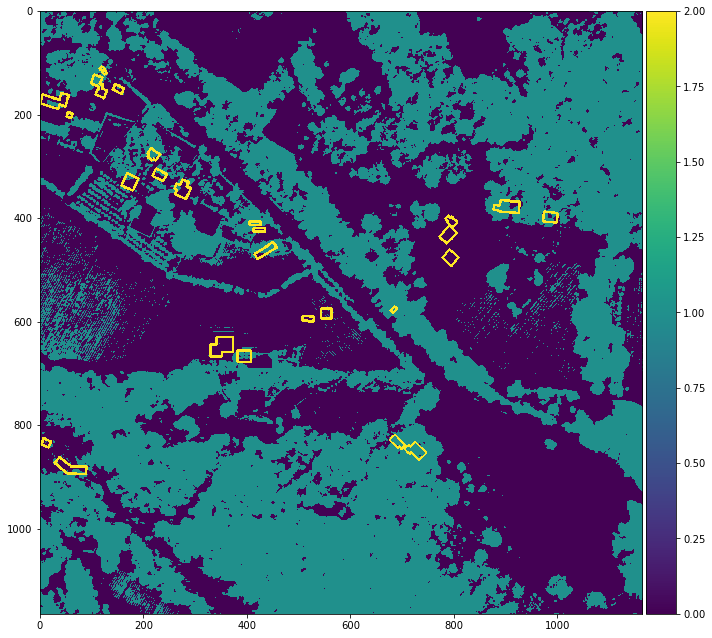

In [197]:
import matplotlib.pyplot as plt
recs = gdf.loc[gdf['cluster']==222,['STRCT_ID','geometry']].to_dict('records')

tester = imread('/mnt/data/the_tiffs/cluster_222.tiff')
extent = cluster_bounds['extent'].values[222]
new_test = (tester>120).astype(np.uint8)
print(new_test.shape)
for rec in recs:
#     drawing = np.zeros(tester.shape,np.uint8)
    contours = np.array(convert_coords(coords =[x for x in rec['geometry'].exterior.coords], xmin=extent[0],ymin=extent[1],xmax=extent[2],ymax=extent[3],multiplier=1000))
    cv2.drawContours(new_test,[contours],0,2,3)
fig, ax = plt.subplots(figsize=(10, 10))
imshow(new_test,ax=ax)


In [198]:
test_cluster = 44


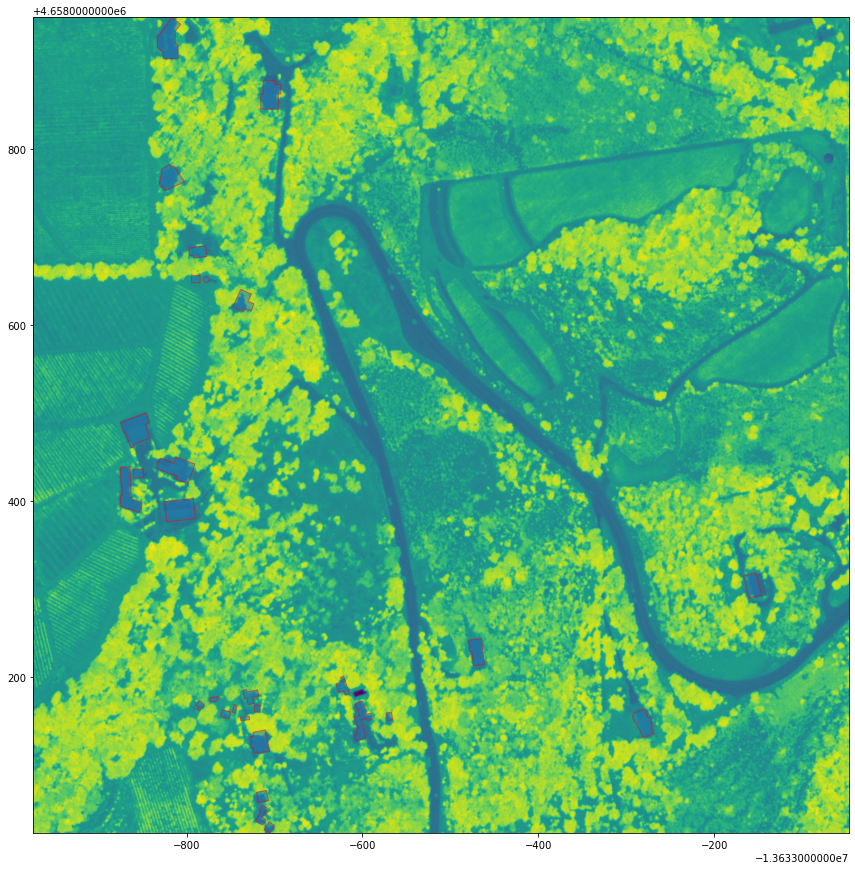

In [199]:
import contextily as ctx
def plot_cluster_with_polygons(cluster_num):
    cluster_bounds_dict = cluster_bounds[cluster_bounds['cluster']==test_cluster].to_dict('records')[0]
    bounds = cluster_bounds_dict['extent']
    source_file = cluster_bounds_dict['tiff_file']
    polygon_df = gdf.loc[gdf['cluster']==cluster_num]
    ylim = [bounds[1],bounds[3]]
    xlim = [bounds[0],bounds[2]]
    ax = polygon_df.plot(figsize=(15,15),edgecolor='red',alpha=.5)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ctx.add_basemap(ax, source=source_file)
    
plot_cluster_with_polygons(test_cluster)

In [200]:
def flatten(t):
    return [item for sublist in t for item in sublist]

tree_cov_cluster = pd.DataFrame(flatten(tree_coverages))

In [201]:
tree_cov_cluster.head()

,STRCT_ID,nvdi_cov_120,nvdi_cov_160,nvdi_score
0,321312540,0.534831,0.0,120.864045
1,321315231,0.000000,0.0,73.549451
2,321315831,0.951833,0.0,129.050459
3,321314608,0.004680,0.0,82.684867
4,321307645,0.313249,0.0,102.048193


In [204]:
gdf.drop(columns=['tree_cov_cluster', 'nvdi_cov_120_x',
       'nvdi_cov_160_x', 'nvdi_cov_single_120', 'nvdi_cov_single_160',
       'nvdi_cov_120_y', 'nvdi_cov_160_y', 'nvdi_cov_120', 'nvdi_cov_160'],inplace=True)

In [205]:
gdf = gdf.merge(tree_cov_cluster,on='STRCT_ID')
gdf.columns

Index(['addresslin', 'city', 'state', 'postcode', 'STRCT_ID', 'FIPS', 'LAG_FT',
       'HAG_FT', 'FFH_FT', 'distance', 'geometry', 'bounds', 'xrange',
       'yrange', 'centroid', 'cluster', 'nvdi_cov_120', 'nvdi_cov_160',
       'nvdi_score'],
      dtype='object')

In [207]:
rerun=True

if rerun:
    oth_tree_covs = Parallel(n_jobs=20,backend='threading')(delayed(calculate_tree_coverage)(geometry=geometry) for geometry in gdf['geometry'].tolist())

In [208]:
gdf['nvdi_cov_single_120'] = [x['nvdi_cov_single_120'] for x in oth_tree_covs]
gdf['nvdi_cov_single_160'] = [x['nvdi_cov_single_160'] for x in oth_tree_covs]
gdf['nvdi_score_single'] = [x['nvdi_score_single'] for x in oth_tree_covs]

In [212]:
gdf[['nvdi_cov_120', 'nvdi_cov_160',
       'nvdi_score', 'nvdi_cov_single_120', 'nvdi_cov_single_160',
       'nvdi_score_single']].describe()

gdf['high_tree_coverage'] = gdf['nvdi_cov_single_120'] >=.2

In [216]:
from shapely.geometry import Polygon
cluster_bounds['geometry'] = cluster_bounds['bounds'].apply(lambda x: Polygon([[x[0],x[1]],[x[0],x[3]],[x[2],x[1]],[x[2],x[3]]]))

In [220]:
cluster_gpd = gpd.GeoDataFrame(cluster_bounds)

In [223]:
cluster_gpd[['cluster','area','geometry']].to_file('nvdi_clusters_glass.shp')

In [228]:
gdf[['addresslin', 'city', 'state', 'postcode', 'STRCT_ID', 'FIPS', 'LAG_FT',
       'HAG_FT', 'FFH_FT', 'distance', 'geometry', 'cluster', 'nvdi_cov_single_120', 
       'nvdi_score_single', 'high_tree_coverage']].to_file('nvdi_polygons_glass.shp')

/tmp/ipykernel_28044/1269974334.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf[['addresslin', 'city', 'state', 'postcode', 'STRCT_ID', 'FIPS', 'LAG_FT',


In [229]:
!zip nvdi_polygons_glass.zip nvdi_polygons_glass*
!zip nvdi_clusters_glass.zip nvdi_clusters_glass*


  adding: nvdi_polygons_glass.cpg (stored 0%)
  adding: nvdi_polygons_glass.dbf (deflated 91%)
  adding: nvdi_polygons_glass.prj (deflated 42%)
  adding: nvdi_polygons_glass.shp (deflated 45%)
  adding: nvdi_polygons_glass.shx (deflated 57%)
  adding: nvdi_clusters_glass.cpg (stored 0%)
  adding: nvdi_clusters_glass.dbf (deflated 63%)
  adding: nvdi_clusters_glass.shp (deflated 69%)
  adding: nvdi_clusters_glass.shx (deflated 69%)


In [230]:
gdf.groupby('cluster')['high_tree_coverage'].mean()

cluster
0      0.169014
1      0.101124
2      0.379310
3      0.304348
4      0.294118
         ...   
295    0.098592
296    0.240000
297    0.397059
298    0.304348
299    0.353846
Name: high_tree_coverage, Length: 300, dtype: float64

In [ ]:
raise

In [ ]:
ax = gdf.plot(figsize=(10,10),column='cluster')

ax.set_ylim([4646904.4361901255,4672389.203090799])
ax.set_xlim([-13649110.888585791,-13623626.121685117])
ax.scatter(x,y[0],color='black',label='Glass Fire Centroid',linewidth=12)
ctx.add_basemap(ax,source='test.tiff')

In [263]:
min_x = gdf['bounds'].apply(lambda x:x[0]).min()
max_x = gdf['bounds'].apply(lambda x:x[2]).max()
min_y = gdf['bounds'].apply(lambda x:x[1]).min()
max_y = gdf['bounds'].apply(lambda x:x[3]).max()

In [264]:
all_bounds = [min_x,min_y,max_x,max_y]

In [265]:
all_bounds

[-13649110.888585791, 4647264.146945555, -13623626.121685117, 4672029.49233537]

In [291]:
resp = create_request(bbox=','.join([str(x) for x in all_bounds]),size='1000,1000',renderingRule='',f='image',format='tiff')
# json.loads(resp.content)

In [292]:
with open('test.tiff','wb') as f:
    f.write(resp.content)

In [188]:
[list(x) for x in gdf['geometry'].values[1].exterior.coords]

[[-13633962.905739617, 4656971.11434011],
 [-13633948.05852257, 4656975.989569257],
 [-13633943.32174443, 4656961.444768413],
 [-13633958.168942664, 4656956.569552841],
 [-13633962.905739617, 4656971.11434011]]

In [207]:
def convert_coords(coords,xmin,ymin,xmax,ymax,multiplier=100,**kwargs):
    new_coords=[]
    
    for x,y in coords:
        new_x = int(((x-xmin)/(xmax-xmin)) * multiplier)
        new_y = int(((y-ymin)/(ymax-ymin)) * multiplier)
        new_coords.append((new_x,new_y))
    return new_coords

convert_coords(coords =[x for x in gdf['geometry'].values[1].exterior.coords], **the_dict['extent'])

{'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}


[(0, 74), (75, 99), (100, 25), (24, 0), (0, 74)]

In [268]:
points = [(0, 74), (75, 99), (100, 25), (24, 0), (0, 74)]

contours = np.array(points)

drawing = np.zeros([100, 100],np.uint8)
cv2.drawContours(drawing,[contours],0,1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [269]:
drawing.shape

(100, 100)

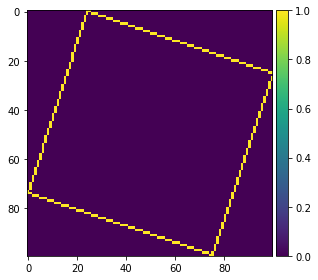

In [270]:
imshow(drawing)

In [196]:
from shapely.geometry import Polygon
new_polygon = Polygon.from_bounds(the_dict['extent']['xmin'],the_dict['extent']['ymin'],the_dict['extent']['xmax'],the_dict['extent']['ymax'])

In [204]:
from shapely.geometry.polygon import LinearRing
oth_polygon = LinearRing([x for x in gdf['geometry'].values[1].exterior.coords])
oth_polygon.project(new_polygon)

third argument of GEOSProject_r must be Point


-1.0

In [272]:
import contextily as ctx

In [301]:
from pyproj import Proj, transform
lat = 38.56295, 
long = -122.49745
P3857 = Proj(init='epsg:3857')
P4326 = Proj(init='epsg:4326')

x,y = transform(P4326, P3857, long, lat)

/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/pyproj/crs/crs.py:306: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/opt/conda/envs/tree-overhang/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

In [308]:
imread('test.jpg').shape

(1000, 1000, 3)

In [310]:
y_diff = 4672389.203090799 - 4646904.4361901255
x_diff = -13623626.121685117- -13649110.888585791

y_diff*x_diff

649473343.9816641

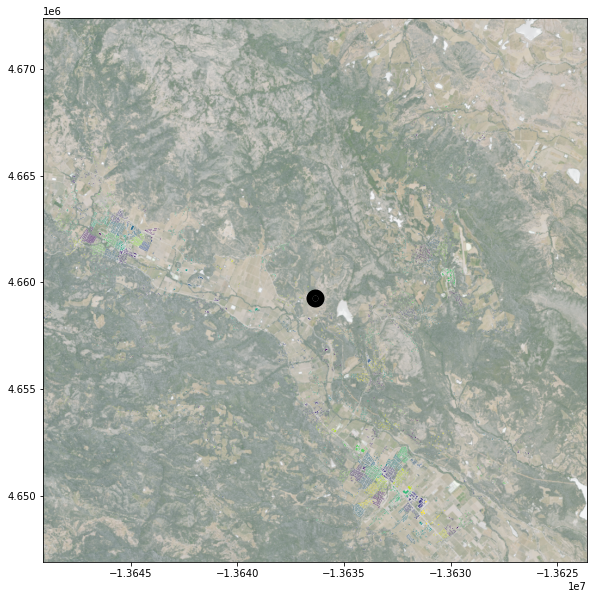

In [331]:
ax = gdf.plot(figsize=(10,10),column='cluster')

ax.set_ylim([4646904.4361901255,4672389.203090799])
ax.set_xlim([-13649110.888585791,-13623626.121685117])
ax.scatter(x,y[0],color='black',label='Glass Fire Centroid',linewidth=12)
ctx.add_basemap(ax,source='test.tiff')

In [233]:
((the_image>120) & (drawing==1)).sum()/(drawing.sum())

0.46283997469955723

In [234]:
contours,_ = cv2.findContours((the_image>120).astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

In [237]:
imsave('test.jpg',the_image)

In [239]:
imread('test.jpg').shape

(100, 100)

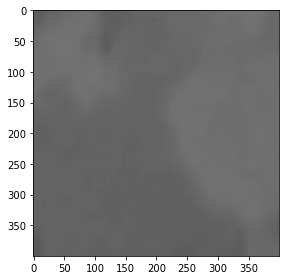

In [65]:
from skimage.io import *
imshow(imread(oth_url))

In [147]:
sample_data = imread('https://map.dfg.ca.gov/arcgis/rest/services/Base_Remote_Sensing/NAIP_2020_NDVI/ImageServer/exportImage?bbox=-13633962.905739617%2C+4656956.569552841%2C+-13633943.32174443%2C+4656975.989569257&bboxSR=&size=100%2C100&imageSR=&time=&format=jpgpng&pixelType=U8&noData=&noDataInterpretation=esriNoDataMatchAny&interpolation=+RSP_BilinearInterpolation&compression=&compressionQuality=&bandIds=&mosaicRule=&renderingRule=&f=image')

In [148]:
sample_data.shape

(100, 100, 3)

In [149]:
sample_data.max()

255

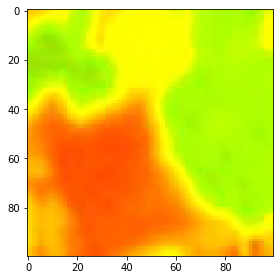

In [155]:
imshow(sample_data)

In [151]:
sample_data.argmax(axis=2).shape

(100, 100)

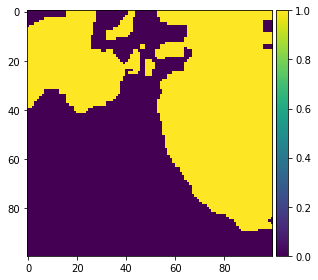

In [152]:
imshow(sample_data.argmax(axis=2))

In [144]:
import numpy as np
imshow((sample_data[:,:,1]>200).astype(np.uint8))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [145]:
sample_data.shape

(400, 400)